# Data explore

In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import re
import os
import sys
sys.path.append('../../pylib')
import cx_lib

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc

In [3]:
plasma = pd.read_csv('../../data/original_data/plasma1.tsv', sep='\t')
plasma_batch = plasma[['Sequence', 'Intensity']+[f'Intensity {i}' for i in range(1, 97)]].replace(0, np.nan).dropna().set_index('Sequence', drop=True)
plasma_batch.head

<bound method NDFrame.head of                       Intensity   Intensity 1   Intensity 2   Intensity 3  \
Sequence                                                                    
VLSALQAVQGLLVAQGR  1.368100e+09  1.368000e+07  1.727000e+07  1.158400e+07   
EIPDEISILLLGVAHFK  1.527100e+09  2.474400e+07  2.557500e+07  1.959600e+07   
FYYLIASETPGK       1.851100e+09  3.186100e+07  3.279700e+07  2.899100e+07   
YQIWTTVVDWIHPDLK   2.068800e+09  2.666800e+07  2.772900e+07  2.743800e+07   
LEYLLLSR           2.083100e+09  3.123100e+07  3.105400e+07  1.809800e+07   
...                         ...           ...           ...           ...   
LVNEVTEFAK         1.989300e+12  4.111900e+10  3.249100e+10  2.964800e+10   
LVTDLTK            2.003100e+12  3.811100e+10  2.188900e+10  3.082100e+10   
KVPQVSTPTLVEVSR    2.434600e+12  4.642700e+10  4.042200e+10  3.872000e+10   
AVMDDFAAFVEK       2.673100e+12  3.920300e+10  3.749300e+10  3.545000e+10   
VFDEFKPLVEEPQNLIK  2.951000e+12  4.398300e+10 

In [5]:
plasma_batch_T = plasma_batch.T

## Normalization

In [6]:
scaler = StandardScaler()
plasma_standard = scaler.fit_transform(plasma_batch_T)
plasma_standard = pd.DataFrame(plasma_standard, columns=plasma_batch_T.columns, index=plasma_batch_T.index)
plasma_standard

Sequence,VLSALQAVQGLLVAQGR,EIPDEISILLLGVAHFK,FYYLIASETPGK,YQIWTTVVDWIHPDLK,LEYLLLSR,LSQLQTYMIQFDQYIK,NALTGLPPGLFQASATLDTLVLK,GHIYQGSEADSVFSGFLIFPSA,GPEEEHLGILGPVIWAEVGDTIR,NTLYLQMNNLR,...,QTALVELVK,DLGEENFK,HPYFYAPELLFFAK,DDNPNLPR,SLHTLFGDK,LVNEVTEFAK,LVTDLTK,KVPQVSTPTLVEVSR,AVMDDFAAFVEK,VFDEFKPLVEEPQNLIK
Intensity,9.795361,9.792876,9.794997,9.794678,9.796035,9.793234,9.791595,9.795159,9.795863,9.793144,...,9.794582,9.794270,9.795500,9.793931,9.794879,9.792720,9.793160,9.795516,9.797021,9.794779
Intensity 1,-0.106210,-0.044149,-0.034072,-0.077288,-0.056271,-0.073121,-0.023914,-0.055127,-0.040629,-0.023350,...,-0.032907,-0.037124,-0.069484,-0.017297,-0.034097,0.000516,-0.015924,-0.015493,-0.059550,-0.057148
Intensity 2,-0.079965,-0.038708,-0.029015,-0.072159,-0.057121,-0.040085,-0.039603,-0.066961,-0.083253,0.000448,...,-0.048136,-0.057434,-0.084688,-0.063779,-0.069172,-0.042851,-0.096904,-0.040163,-0.065949,-0.078472
Intensity 3,-0.121533,-0.077857,-0.049579,-0.073566,-0.119331,-0.051572,-0.029588,-0.083315,-0.097278,-0.025710,...,-0.064085,-0.062547,-0.059881,-0.065769,-0.061467,-0.057141,-0.052316,-0.047155,-0.073594,-0.072419
Intensity 4,-0.094666,-0.074308,-0.056856,-0.090388,-0.075420,-0.086223,-0.074451,-0.058588,-0.057755,-0.015203,...,-0.053295,-0.010820,-0.074032,-0.045799,-0.061461,-0.033005,-0.038049,-0.048244,-0.079031,-0.063418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Intensity 92,-0.110808,-0.086172,-0.123938,-0.112166,-0.128502,-0.108327,-0.123115,-0.116802,-0.124066,-0.111170,...,-0.131854,-0.116831,-0.142991,-0.114917,-0.102495,-0.119649,-0.118843,-0.124914,-0.115503,-0.098684
Intensity 93,-0.071558,-0.056983,-0.101884,-0.083911,-0.068188,-0.130146,-0.074801,-0.102651,-0.118768,-0.120274,...,-0.118734,-0.101146,-0.091207,-0.115586,-0.116165,-0.106535,-0.108355,-0.117088,-0.099438,-0.097775
Intensity 94,-0.131892,-0.040450,-0.121955,-0.070931,-0.106328,-0.077203,-0.051756,-0.091916,-0.097355,-0.131678,...,-0.107576,-0.120516,-0.109906,-0.101368,-0.106282,-0.198832,-0.103932,-0.112886,-0.114302,-0.103110
Intensity 95,-0.095617,-0.082597,-0.105260,-0.070467,-0.109449,-0.078385,-0.068917,-0.088508,-0.080947,-0.124419,...,-0.113943,-0.114855,-0.128662,-0.138866,-0.119340,-0.113964,-0.135606,-0.116324,-0.108812,-0.101374


In [7]:
pca=PCA(n_components=4)
plasma_pca = pca.fit_transform(plasma_standard)
plasma_pca = pd.DataFrame(plasma_pca, columns = [f"PC{i+1}" for i in range(plasma_pca.shape[1])], index=plasma_batch_T.index)
pca.explained_variance_ratio_

array([9.99260263e-01, 1.55018881e-04, 1.29968543e-04, 4.81417093e-05])

In [8]:
components = pca.components_.T * np.sqrt(pca.explained_variance_)
components = pd.DataFrame(components, columns=plasma_pca.columns, index=plasma_standard.columns)
components

,PC1,PC2,PC3,PC4
Sequence,,,,
VLSALQAVQGLLVAQGR,1.004736,-0.003811,-0.025534,0.000448
EIPDEISILLLGVAHFK,1.004867,0.014590,-0.014644,-0.000180
FYYLIASETPGK,1.005060,-0.007887,0.000839,-0.001175
YQIWTTVVDWIHPDLK,1.004933,0.008827,-0.015199,-0.002356
LEYLLLSR,1.005052,-0.005533,-0.007248,0.000927
...,...,...,...,...
LVNEVTEFAK,1.004754,-0.012808,-0.000948,-0.005144
LVTDLTK,1.005051,0.002089,0.012807,0.001879
KVPQVSTPTLVEVSR,1.005129,-0.007887,0.005016,-0.000883


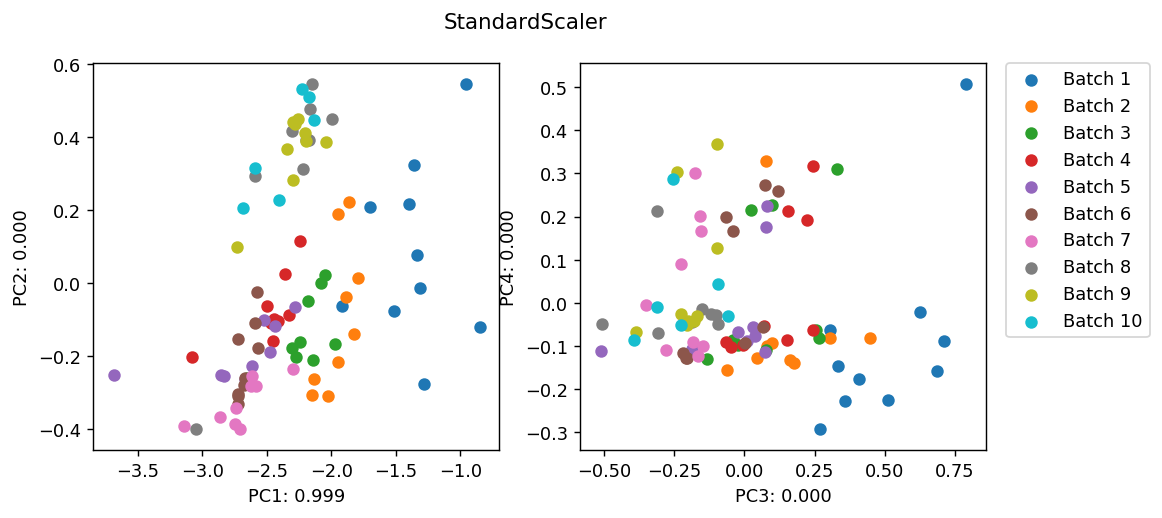

In [10]:
fig = plt.figure(dpi=128, figsize = (9,4))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)


ax1.scatter(plasma_pca['Intensity 1':'Intensity 10']['PC1'],plasma_pca['Intensity 1':'Intensity 10']['PC2'])
ax1.scatter(plasma_pca['Intensity 11':'Intensity 19']['PC1'],plasma_pca['Intensity 11':'Intensity 19']['PC2'])
ax1.scatter(plasma_pca['Intensity 21':'Intensity 29']['PC1'],plasma_pca['Intensity 21':'Intensity 29']['PC2'])
ax1.scatter(plasma_pca['Intensity 31':'Intensity 39']['PC1'],plasma_pca['Intensity 31':'Intensity 39']['PC2'])
ax1.scatter(plasma_pca['Intensity 41':'Intensity 49']['PC1'],plasma_pca['Intensity 41':'Intensity 49']['PC2'])
ax1.scatter(plasma_pca['Intensity 51':'Intensity 59']['PC1'],plasma_pca['Intensity 51':'Intensity 59']['PC2'])
ax1.scatter(plasma_pca['Intensity 61':'Intensity 69']['PC1'],plasma_pca['Intensity 61':'Intensity 69']['PC2'])
ax1.scatter(plasma_pca['Intensity 71':'Intensity 79']['PC1'],plasma_pca['Intensity 71':'Intensity 79']['PC2'])
ax1.scatter(plasma_pca['Intensity 81':'Intensity 89']['PC1'],plasma_pca['Intensity 81':'Intensity 89']['PC2'])
ax1.scatter(plasma_pca['Intensity 91':'Intensity 96']['PC1'],plasma_pca['Intensity 91':'Intensity 96']['PC2'])
ax1.set_xlabel("PC1: %0.3f" % pca.explained_variance_ratio_[0])
ax1.set_ylabel("PC2: %0.3f" % pca.explained_variance_ratio_[1])

ax2.scatter(plasma_pca['Intensity 1':'Intensity 10']['PC3'],plasma_pca['Intensity 1':'Intensity 10']['PC4'])
ax2.scatter(plasma_pca['Intensity 11':'Intensity 19']['PC3'],plasma_pca['Intensity 11':'Intensity 19']['PC4'])
ax2.scatter(plasma_pca['Intensity 21':'Intensity 29']['PC3'],plasma_pca['Intensity 21':'Intensity 29']['PC4'])
ax2.scatter(plasma_pca['Intensity 31':'Intensity 39']['PC3'],plasma_pca['Intensity 31':'Intensity 39']['PC4'])
ax2.scatter(plasma_pca['Intensity 41':'Intensity 49']['PC3'],plasma_pca['Intensity 41':'Intensity 49']['PC4'])
ax2.scatter(plasma_pca['Intensity 51':'Intensity 59']['PC3'],plasma_pca['Intensity 51':'Intensity 59']['PC4'])
ax2.scatter(plasma_pca['Intensity 61':'Intensity 69']['PC3'],plasma_pca['Intensity 61':'Intensity 69']['PC4'])
ax2.scatter(plasma_pca['Intensity 71':'Intensity 79']['PC3'],plasma_pca['Intensity 71':'Intensity 79']['PC4'])
ax2.scatter(plasma_pca['Intensity 81':'Intensity 89']['PC3'],plasma_pca['Intensity 81':'Intensity 89']['PC4'])
ax2.scatter(plasma_pca['Intensity 91':'Intensity 96']['PC3'],plasma_pca['Intensity 91':'Intensity 96']['PC4'])
ax2.set_xlabel("PC3: %0.3f" % pca.explained_variance_ratio_[2])
ax2.set_ylabel("PC4: %0.3f" % pca.explained_variance_ratio_[3])
fig.suptitle('StandardScaler')


plt.legend([f"Batch {i}" for i in range(1,11)],bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0)

plt.show()

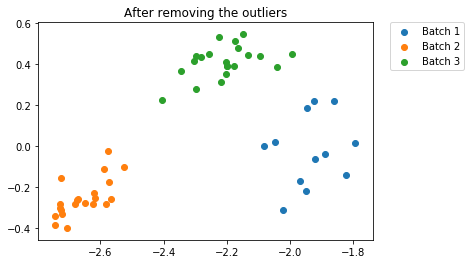

In [11]:
plt.scatter(plasma_pca.T[[f'Intensity {i}' for i in [10,12,14,15,16,17,18,19,20,21,22,25]]].T['PC1'],
            plasma_pca.T[[f'Intensity {i}' for i in [10,12,14,15,16,17,18,19,20,21,22,25]]].T['PC2'])
plt.scatter(plasma_pca.T[[f'Intensity {i}' for i in [42,47,49,50,51,52,53,54,55,56,57,58,59,60,61,62,64,66,67,69,70]]].T['PC1'],
            plasma_pca.T[[f'Intensity {i}' for i in [42,47,49,50,51,52,53,54,55,56,57,58,59,60,61,62,64,66,67,69,70]]].T['PC2'])
plt.scatter(plasma_pca.T[[f'Intensity {i}' for i in [72,73,74,75,76,77,78,80,81,82,83,85,86,87,88,89,90,91,93,94,95]]].T['PC1'],
            plasma_pca.T[[f'Intensity {i}' for i in [72,73,74,75,76,77,78,80,81,82,83,85,86,87,88,89,90,91,93,94,95]]].T['PC2'])

plt.title('After removing the outliers')
plt.legend([f"Batch {i}" for i in range(1,4)],bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0)
plt.show()

# Build data set

## Batch 1 and 2 are used for further study 

In [31]:
filtered_columns = ['Sequence']+ \
                    [f'Intensity {i}' for i in [10,12,14,15,16,17,18,19,20,21,22,25]]+ \
                    [f'Intensity {i}' for i in [42,47,49,50,51,52,53,54,55,56,57,58,59,60,61,62,64,66,67,69,70]]
data = plasma[filtered_columns]


data.columns = ['Sequence'] + [f'Batch1_{i}' for i in range(1,13)] + [f'Batch2_{i}' for i in range(1,22)]

batch = data.replace(0, np.nan).dropna().set_index('Sequence', drop=True)
batch

,Batch1_1,Batch1_2,Batch1_3,Batch1_4,Batch1_5,Batch1_6,Batch1_7,Batch1_8,Batch1_9,Batch1_10,...,Batch2_12,Batch2_13,Batch2_14,Batch2_15,Batch2_16,Batch2_17,Batch2_18,Batch2_19,Batch2_20,Batch2_21
Sequence,,,,,,,,,,,,,,,,,,,,,
EEFHEQSFR,1.370800e+07,8.954100e+06,1.322200e+07,1.475000e+07,1.284700e+07,1.493100e+07,1.318500e+07,8.954200e+06,1.277400e+07,1.105200e+07,...,6.636100e+06,6.640000e+06,9.067500e+06,7.486100e+06,9.320200e+06,7.535700e+06,5.792000e+06,7.076700e+06,6.052200e+06,6.062300e+06
LWAYLTINQLLAER,1.249900e+07,1.247500e+07,1.238300e+07,1.348700e+07,1.430200e+07,1.473800e+07,9.252100e+06,1.153600e+07,1.120700e+07,1.089900e+07,...,8.648500e+06,1.121500e+07,1.037800e+07,9.183300e+06,9.775400e+06,1.069800e+07,1.039200e+07,8.954200e+06,8.048200e+06,7.309400e+06
QPVPGQQMTLK,1.418900e+07,1.210400e+07,1.392700e+07,1.254200e+07,1.372500e+07,1.826600e+07,8.610400e+06,7.445400e+06,7.115900e+06,1.196800e+07,...,7.636900e+06,6.813500e+06,1.248800e+07,1.039900e+07,9.928000e+06,1.322900e+07,1.419500e+07,1.080500e+07,1.170400e+07,1.587800e+07
TTLTAFGFASADLIEIGLEGK,1.805100e+07,1.431900e+07,1.704000e+07,1.899400e+07,1.707100e+07,1.645700e+07,1.539200e+07,1.719600e+07,5.251000e+06,1.821400e+07,...,5.829600e+06,3.743400e+06,5.340200e+06,1.448900e+07,1.451300e+07,1.685200e+07,1.453000e+07,1.388000e+07,1.570000e+07,5.095800e+06
SALVLQYLR,1.050900e+07,1.223100e+07,9.201200e+06,1.154700e+07,8.031600e+06,1.054800e+07,9.637600e+06,1.345300e+07,1.723600e+07,1.068600e+07,...,9.202500e+06,8.878900e+06,8.946200e+06,9.372900e+06,6.931900e+06,8.806800e+06,9.704900e+06,6.155200e+06,1.088000e+07,9.259900e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LVNEVTEFAK,2.735000e+10,2.593300e+10,2.449300e+10,2.582800e+10,2.667000e+10,2.492700e+10,2.626000e+10,1.103600e+09,2.546800e+10,2.402500e+10,...,2.014800e+10,1.765700e+10,1.768900e+10,2.053100e+10,1.865300e+10,1.948600e+10,1.812300e+10,1.992800e+10,1.861800e+10,1.741100e+10
LVTDLTK,2.540600e+10,2.705400e+10,2.141100e+10,2.602000e+10,2.282600e+10,2.324400e+10,2.880100e+10,2.676200e+10,2.629900e+10,2.584800e+10,...,1.743700e+10,1.218800e+10,1.474300e+10,1.760400e+10,1.527000e+10,2.026600e+10,1.395700e+10,1.452400e+10,1.623800e+10,1.602700e+10
KVPQVSTPTLVEVSR,3.041000e+10,2.917900e+10,2.979300e+10,3.124700e+10,3.051600e+10,2.884100e+10,2.879000e+10,2.970000e+10,2.924300e+10,2.769200e+10,...,2.297100e+10,2.232800e+10,2.183200e+10,2.103500e+10,2.400700e+10,2.222300e+10,2.260000e+10,2.152200e+10,2.238100e+10,2.156800e+10


In [32]:
batch_T = batch.T
scaler = StandardScaler()
batch_standard = scaler.fit_transform(batch_T)
batch_standard = pd.DataFrame(batch_standard, columns=batch_T.columns, index=batch_T.index)
batch_standard

Sequence,EEFHEQSFR,LWAYLTINQLLAER,QPVPGQQMTLK,TTLTAFGFASADLIEIGLEGK,SALVLQYLR,NSITLTNLTPGTEYVVSIVALNGR,VAGLLEDTFPGLLGLR,LAKTYETTLEK,LWAYLTIQQLLEQTVSASDADQQALR,NGESVKLHLETDSLALVALGALDTALYAAGSK,...,QTALVELVK,DLGEENFK,HPYFYAPELLFFAK,DDNPNLPR,SLHTLFGDK,LVNEVTEFAK,LVTDLTK,KVPQVSTPTLVEVSR,AVMDDFAAFVEK,VFDEFKPLVEEPQNLIK
Batch1_1,1.677138,0.957635,1.108740,1.104594,0.449125,1.121103,-1.431146,2.485590,0.868645,0.611476,...,1.075437,1.441604,0.741906,2.105970,1.367776,1.402108,1.205323,1.504145,1.807672,0.597185
Batch1_2,-0.065813,0.944334,0.330279,0.322989,1.229103,-0.104129,2.922919,1.330791,-0.654267,-0.449033,...,1.677125,1.176842,1.247771,0.871650,0.732913,1.100747,1.541649,1.170221,1.036273,0.701191
Batch1_3,1.498953,0.893344,1.010919,0.892857,-0.143242,0.135874,1.330371,0.713476,2.312611,0.549566,...,0.327154,0.704191,1.419697,0.501886,0.216094,0.794494,0.390018,1.336776,0.877671,0.656242
Batch1_4,2.059173,1.505222,0.493812,1.302089,0.919286,1.207191,1.055314,0.721046,1.473532,0.999023,...,1.063502,0.228327,1.232476,0.932036,2.242835,1.078416,1.330629,1.731193,1.566489,0.965197
Batch1_5,1.361464,1.956926,0.935500,0.899349,-0.673011,1.110234,-1.062011,0.348042,1.816220,1.028754,...,0.210657,1.114829,1.328211,0.736513,1.908423,1.257489,0.678793,1.532899,1.476190,1.296681
Batch1_6,2.125534,2.198573,2.630940,0.770757,0.466790,1.624153,1.283410,0.051428,1.915454,1.733894,...,1.090745,1.470522,1.138441,0.845048,0.979135,0.886795,0.764099,1.078534,0.541945,0.633494
Batch1_7,1.485387,-0.841919,-0.974101,0.547711,0.054425,-0.792224,-1.378457,1.986646,1.492497,0.412805,...,0.978140,1.696405,-1.318375,1.315633,1.010905,1.170292,1.898179,1.064699,0.586322,0.723173
Batch1_8,-0.065777,0.423904,-1.409069,0.925528,1.782607,-1.749627,-0.184252,0.719440,0.529485,1.680379,...,1.137967,2.174198,1.174695,1.659327,1.852550,-4.179859,1.482057,1.311549,0.154895,0.851349
Batch1_9,1.334700,0.241560,-1.532092,-1.576153,3.496113,-1.025749,-0.327664,0.361347,0.415476,2.668135,...,1.009794,1.714078,0.528910,1.451833,0.602544,1.001853,1.387567,1.187581,0.316970,0.722080
Batch1_10,0.703353,0.070855,0.279502,1.138731,0.529297,-1.236056,-0.259235,1.180764,0.189663,1.626514,...,1.026140,0.175953,0.363215,1.366974,1.194134,0.694962,1.295527,0.766852,0.532298,0.709284


In [33]:
pca2 = PCA(n_components=4)
batch_pca = pca2.fit_transform(batch_standard)
batch_pca = pd.DataFrame(batch_pca, columns = [f"PC{i+1}" for i in range(batch_pca.shape[1])], index=batch_T.index)
print(pca2.explained_variance_ratio_)
print(batch_pca)

[0.49656177 0.09705065 0.03434609 0.0311257 ]
                 PC1        PC2        PC3        PC4
Batch1_1   26.958420  -1.701761   5.828261  -5.500287
Batch1_2   20.770465   9.399610  16.197444   0.909798
Batch1_3   17.121377  16.763202   3.040763   0.016056
Batch1_4   31.274784   6.437166  -4.748418   0.089687
Batch1_5   28.607537  10.290022  -5.355577   1.453648
Batch1_6   26.156366  10.327031  -5.312475   4.003125
Batch1_7   29.919080 -14.859437   1.085419  -5.536774
Batch1_8   28.212797  -9.358993  -2.608277   0.493120
Batch1_9   26.320229 -12.584727  -3.389097  -0.124057
Batch1_10  19.670239 -10.238640  -1.926908  -2.538280
Batch1_11  18.363836  -8.454882   6.070517  -4.038219
Batch1_12  18.767843  17.059729  -2.110743   4.157927
Batch2_1   -4.867985  -3.665036  -4.506925   4.563653
Batch2_2  -11.176831  -4.809084   6.176364   0.732205
Batch2_3  -15.469986   4.425750  -4.825620  -2.702684
Batch2_4   -9.333721   1.984854  -4.223803   4.303006
Batch2_5  -17.060176   4.100017  -5.

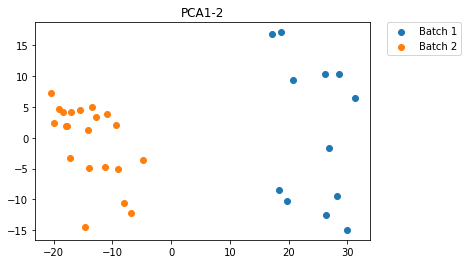

In [34]:
plt.scatter(batch_pca.loc['Batch1_1':'Batch1_12',:]['PC1'], batch_pca.loc['Batch1_1':'Batch1_12',:]['PC2'])
plt.scatter(batch_pca.loc['Batch2_1':'Batch2_21',:]['PC1'], batch_pca.loc['Batch2_1':'Batch2_21',:]['PC2'])

plt.title('PCA1-2')
plt.legend([f"Batch {i}" for i in range(1,3)],bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0)
plt.show()

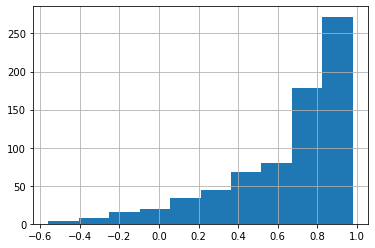

In [39]:
components2 = pca2.components_.T * np.sqrt(pca2.explained_variance_)
components2 = pd.DataFrame(components2, columns=batch_pca.columns, index=batch_standard.columns)
components2['PC1'].hist()

In [61]:
stable = components2[np.abs(components2['PC1']) < 0.5 ][:]
stable['Label'] = 1

unstable = components2[components2['PC1'] > 0.87 ][:]
unstable['Label'] = 0
plasma_data = pd.concat([stable, unstable], axis=0).reset_index()
plasma_data['Length'] = plasma_data.apply(lambda x: len(x['Sequence']), axis=1)
plasma_data[['Sequence', 'Length', 'Label']].sample(frac=1, random_state=1).to_csv('../../data/original_data/plasma1/plasma_data.csv', index=False)

## Add features with ```scripts/R/peptides.R```

# Prediction 

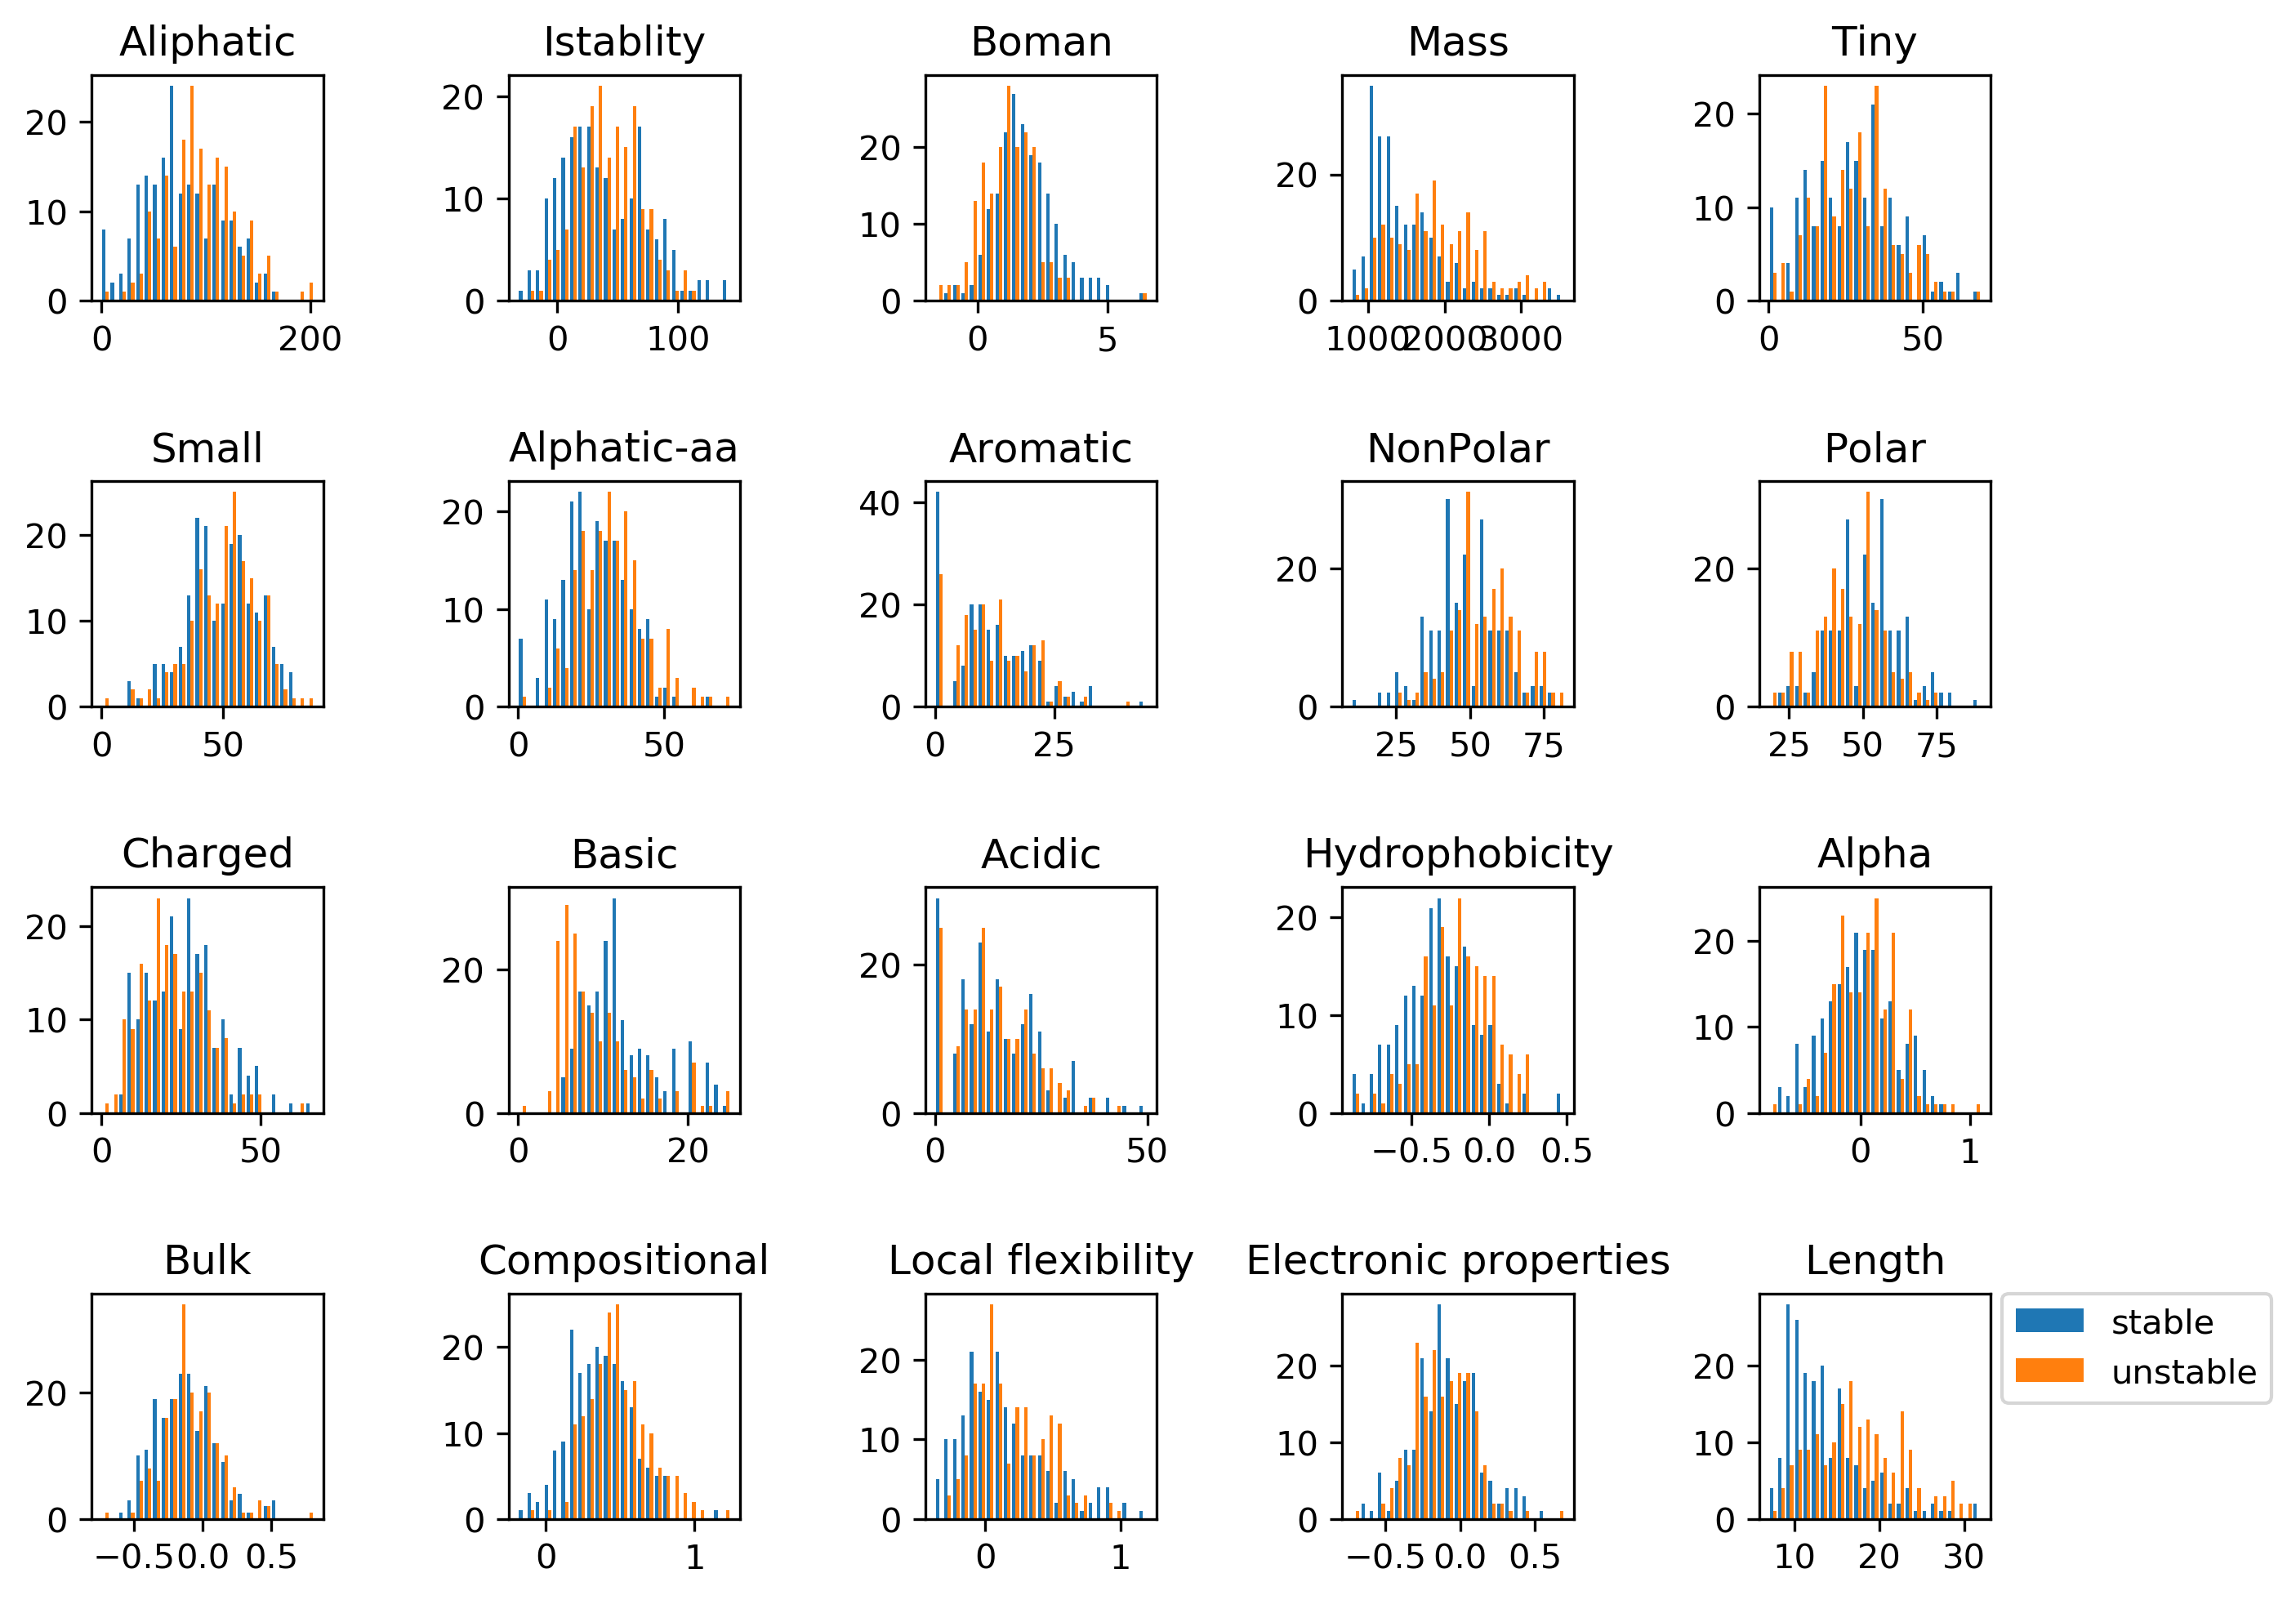

In [3]:
data_set = pd.read_csv('../../data/original_data/plasma1/plasma_trainSet.csv').reset_index(drop=True)
features = ['Aliphatic', 'Istablity', 'Boman', 'Mass', 'Tiny', 'Small',
       'Alphatic-aa', 'Aromatic', 'NonPolar', 'Polar', 'Charged', 'Basic',
       'Acidic', 'Hydrophobicity', 'Alpha', 'Bulk', 'Compositional', 'Local flexibility', 
        'Electronic properties', 'Length']
cx_lib.feature_comparison(data_set, features, 5, 5)

In [4]:
%%time
X ,y = data_set[features], data_set['Label']

lr_sel = RFE(estimator=LogisticRegression(max_iter = 10000), n_features_to_select=10, step=1)
lr_sel.fit_transform(X, y)
dt_sel = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10, step=1)
dt_sel.fit_transform(X, y)
sv_sel = RFE(estimator=SVC(kernel="linear"), n_features_to_select=10, step=1)
sv_sel.fit_transform(X, y)
lr_fea = X.columns[lr_sel.get_support()]
dt_fea = X.columns[dt_sel.get_support()]
sv_fea = X.columns[sv_sel.get_support()]

Wall time: 16.2 s


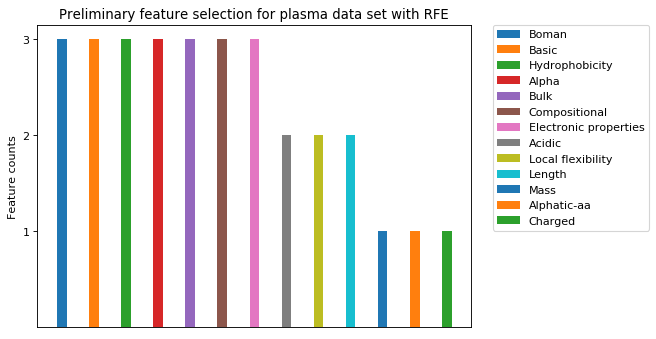

In [5]:
fea_stat = {}
for fea in [lr_fea, dt_fea, sv_fea]:
    for i in fea:
        fea_stat[i] = fea_stat.get(i, 0)+1
fea_stat = {k:v for k,v in sorted(fea_stat.items(), key=lambda d: d[1], reverse=True) }

plt.figure(dpi=80, figsize = (7,5))
for i, key in enumerate(fea_stat):
    plt.bar(i, fea_stat[key], width=0.3)
# plt.xticks(np.arange(len(fea_stat))-0.05, fea_stat.keys(), rotation=75)
plt.xticks([])
plt.yticks([1,2,3])
plt.legend(fea_stat.keys(),bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0)
plt.ylabel('Feature counts')
plt.title('Preliminary feature selection for plasma data set with RFE')
plt.show()

In [8]:
fea_stat.keys()

dict_keys(['Boman', 'Basic', 'Hydrophobicity', 'Alpha', 'Bulk', 'Compositional', 'Electronic properties', 'Acidic', 'Local flexibility', 'Length', 'Mass', 'Alphatic-aa', 'NonPolar'])

# Model Training 

## Logistic regression

In [56]:
%%time
lr_features = ['Length','Boman','Basic','Hydrophobicity', 'Alpha']


X_train, X_test, y_train, y_test = train_test_split(data_set[lr_features], data_set['Label'], test_size=0.3, random_state=0)

def PolynomialLR(degree, C):
    return Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('std_scaler', StandardScaler()),
        ('log_reg', LogisticRegression(C=C, max_iter=5000))
    ])

best_degree, best_C, best_score = 0, 0, 0
for d in range(1,4):
    for c in np.arange(0.1, 1.0, 0.1):
        poly_lr = PolynomialLR(degree=d, C=c)
        scores = cross_val_score(poly_lr, X_train, y_train)
        score = np.mean(scores)
        if score > best_score:
            best_degree, best_C, best_score = d, c, score
            
print("Best degree =", best_degree)
print("Best C =", best_C)
print("Best Score =", best_score)

Best degree = 1
Best C = 0.2
Best Score = 0.7373730043541364
Wall time: 1.12 s


In [57]:
best_lr_clf = PolynomialLR(degree=best_degree, C=best_C)
best_lr_clf.fit(X_train, y_train)
print(best_lr_clf.score(X_test, y_test))

lr_prob = best_lr_clf.predict_proba(X_test)[:,1]
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_prob)
lr_auc = auc(lr_fpr, lr_tpr)

0.7631578947368421


## Support Vector Machine

In [15]:
svc_features = [ 'Boman', 'Mass', 'Tiny','Aromatic', 'Bulk',  'Acidic']
X_train, X_test, y_train, y_test = train_test_split(data_set[svc_features], data_set['Label'], test_size=0.3, random_state=0)


def PolynomialKernelSVC(degree, C, kernel):
    return Pipeline([
        ("std_scaler", StandardScaler()),
        ("kernelSVC", SVC(kernel=kernel, degree=degree, C=C, probability=True))
    ])

best_degree, best_C, best_score , best_kernel = 0, 0, 0, ''
for k in ['linear','poly', 'rbf', 'sigmoid']:
    for d in [1,2]:
        for c in [0.5, 1.0, 2.0, 5.0, 10.0]:
            poly_svc = PolynomialKernelSVC(degree=d, C=c, kernel=k)
            scores = cross_val_score(poly_svc, X_train, y_train)
            score = np.mean(scores)
            if score > best_score:
                best_degree, best_C, best_score, best_kernel = d, c, score, k
            
print("Best degree =", best_degree)
print("Best C =", best_C)
print("Best Kernel =", best_kernel)
print("Best Score =", best_score)

Best degree = 1
Best C = 10.0
Best Kernel = linear
Best Score = 0.7566763425253991


In [18]:
best_svc_clf = PolynomialKernelSVC(degree=best_degree, C=best_C, kernel=best_kernel)
best_svc_clf.fit(X_train, y_train)
print(best_svc_clf.score(X_test, y_test))

svc_prob = best_svc_clf.predict_proba(X_test)[:,1]
svc_fpr, svc_tpr, _ = roc_curve(y_test, svc_prob)
svc_auc = auc(svc_fpr, svc_tpr)

0.7631578947368421


## Random Forest Classifier

In [51]:
%%time
rf_features = [ 'Boman', 'Mass', 'Basic',  'Compositional', 'Electronic properties']
X_train, X_test, y_train, y_test = train_test_split(data_set[rf_features], data_set['Label'], test_size=0.3)

best_score = 0
for n in range(100,1000,200):
    rf_clf = RandomForestClassifier(n_estimators=n, oob_score=True,  n_jobs=-1, random_state=0)
    scores = cross_val_score(rf_clf, X_train, y_train)
    score = np.mean(scores)
    if score > best_score:
        best_n, best_score= n, score

        
print("Best number of clf =", best_n)
print("Best Score =", best_score)   

Best number of clf = 900
Best Score = 0.7643686502177068
Wall time: 16.5 s


In [52]:
best_rf_clf = RandomForestClassifier(n_estimators=best_n, oob_score=True,  n_jobs=-1, random_state=0)
best_rf_clf.fit(X_train, y_train)
print(best_rf_clf.oob_score_)

rf_prob = best_rf_clf.predict_proba(X_test)[:,1]
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_prob)
rf_auc = auc(rf_fpr, rf_tpr)

0.7490494296577946


##  AdaBoost Classifier

In [53]:
%%time
ada_features = [ 'Boman', 'Mass', 'Basic',  'Compositional', 'Electronic properties']
X_train, X_test, y_train, y_test = train_test_split(data_set[ada_features], data_set['Label'], test_size=0.3, random_state=0)


best_depth, best_estimators, best_score = 0, 0, 0

for d in [1,2,3]:
    for e in range(100,600, 100):
        ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=d), n_estimators=e, random_state=0)
        scores = cross_val_score(ada_clf, X_train, y_train)
        score = np.mean(scores)
        if score > best_score:
            best_depth, best_estimators, best_score = d, e, score

print("Best depth =", best_depth)
print("Best Estimators =", best_estimators)
print("Best Score =", best_score)

Best depth = 1
Best Estimators = 200
Best Score = 0.6426705370101595
Wall time: 24.6 s


In [54]:
best_ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=100, random_state=0)
best_ada_clf.fit(X_train, y_train)
score = best_ada_clf.score(X_test, y_test)
print(score)

feature_importances = pd.DataFrame(best_ada_clf.feature_importances_, columns = ['Importance'], index=ada_features)

ada_prob = best_ada_clf.predict_proba(X_test)[:,1]
ada_fpr, ada_tpr, _ = roc_curve(y_test, ada_prob)
ada_auc = auc(ada_fpr, ada_tpr)

0.7192982456140351


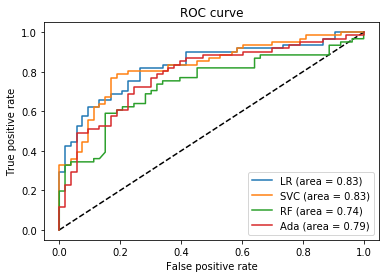

In [58]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(lr_fpr, lr_tpr, label='LR (area = %0.2f)' % lr_auc)
plt.plot(svc_fpr, svc_tpr, label='SVC (area = %0.2f)' % svc_auc)
plt.plot(rf_fpr, rf_tpr, label='RF (area = %0.2f)' % rf_auc)
plt.plot(ada_fpr, ada_tpr, label='Ada (area = %0.2f)' % ada_auc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()